<IPython.core.display.Javascript object>


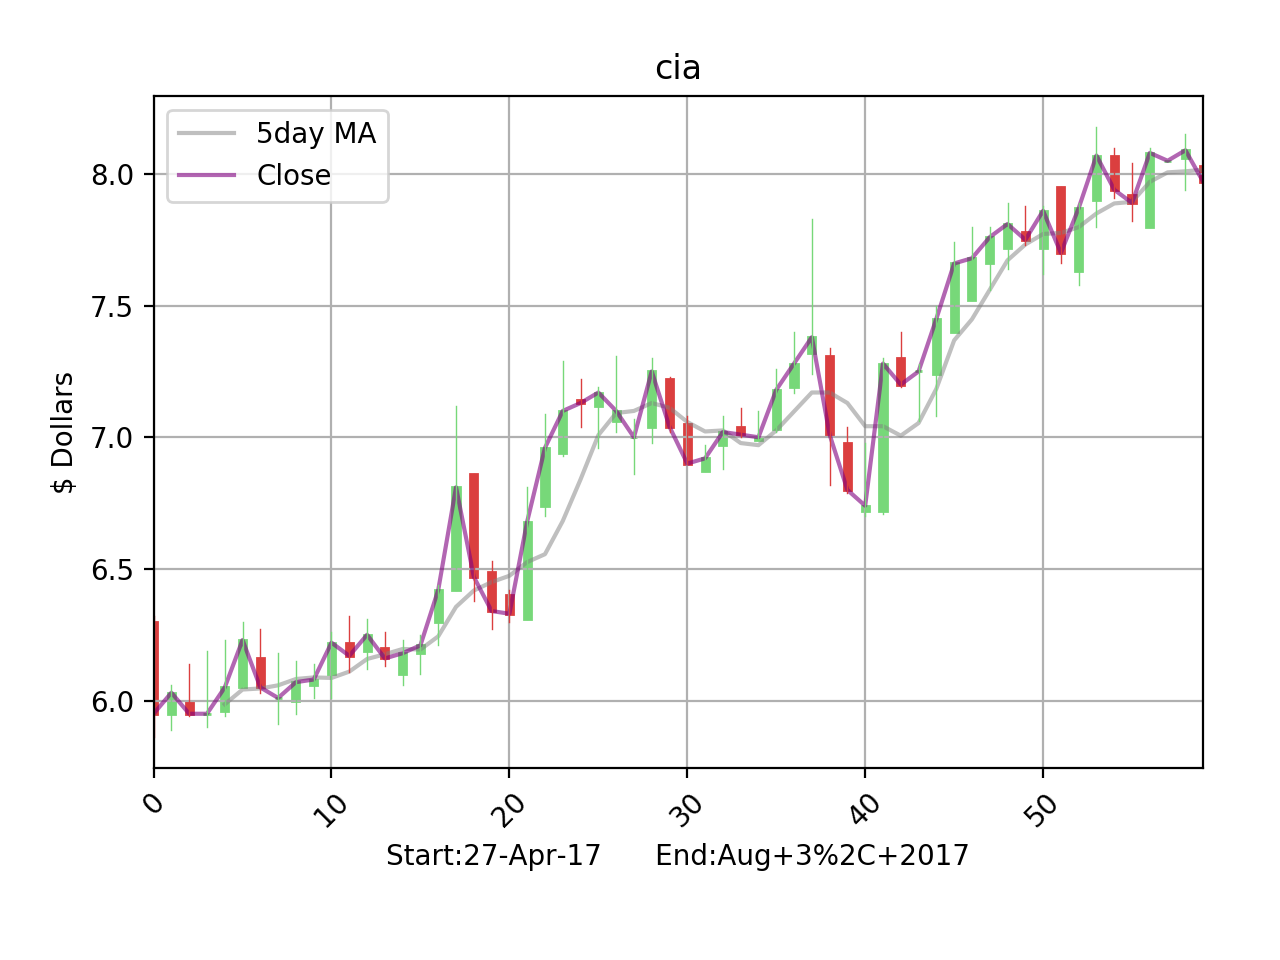

URL is: http://www.google.com/finance/historical?q=cia&startdate=Jan+7%2C+2016&enddate=Aug+3%2C+2017&output=csv
['2017-04-27|cia', 5.95, 6.03, 5.95, 5.95, 6.05, 6.23, 6.05, 6.01, 6.07, 6.08, 6.22, 6.17, 6.25, 6.16, 6.18, 6.21, 6.42, 6.81, 6.47, 6.34, 6.33, 6.68, 6.96, 7.1, 7.13, 7.17, 7.1, 7.0, 7.25, 7.04, 6.9, 6.92, 7.02, 7.01, 7.0, 7.18, 7.28, 7.38, 7.01, 6.8, 6.74, 7.28, 7.2, 7.25, 7.45, 7.66, 7.68, 7.76, 7.81, 7.75, 7.86, 7.7, 7.87, 8.07, 7.94, 7.89, 8.08, 8.05, 8.09, 7.97]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:147: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=5,center=False).mean()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:150: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=1,center=False).mean()


In [86]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.finance import candlestick_ohlc

import numpy as np
import urllib
import datetime as dt
from datetime import datetime
import pandas as pd
import csv
import time

#url = "https://raw.github.com/datasets/gdp/master/data/gdp.csv"

#datareader = csv.reader(io.TextIOWrapper(webpage))

# convert "yyyymmdd" to float
def yyyymmdd2num(s):
    return mdates.date2num(dt.datetime(int(s[0:4]), int(s[4:6]), int(s[6:8])))


def graph_data(stock,start,end):
    fig = plt.figure()
    ax1 = plt.subplot2grid((1,1), (0,0))
    #ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

    url= "http://www.google.com/finance/historical?q="+stock+"&startdate=Jan+7%2C+2016&enddate="+end+"&output=csv"
    #url= "http://www.google.com/finance/historical?q="+stock+"&startdate=Apr+17%2C+2017&enddate=Jul+30%2C+2017&output=csv"
    source_code = urllib.request.urlopen(url).read().decode()
    
    print('URL is: '+url)

    stock_data = []
    split_source = source_code.split('\n')
    for line in split_source:
        split_line = line.split()
        if 'Volume' not in line:
            stock_data.append(line)
    

    date_arr = []
    reader = csv.reader(stock_data)
    your_list = list(reader) 
    x = 0
    stopnow = 0
    
    #flip days so the chart runs the right way
    for line in stock_data:
        if line != '':
            date, openp, highp, lowp, closep, volume = line.split(',')
            
            date_object = datetime.strptime(date, '%d-%b-%y')
            #print(date_object.strftime('%Y-%m-%d'))
            
            date_arr.append(date_object.strftime('%Y-%m-%d'))
            x+=1
            
            if date == start:
                stopnow = 1
                break
        if stopnow == 1:
            break
    date_arr.reverse()
    
    
    #get rest of chart data and add day
    temp_ohlc = []
    x = 0
    stopnow = 0
    
    for line in stock_data:
        if line != '':
            date, openp, highp, lowp, closep, volume = line.split(',')
            
            if x == 0:
                straight_line_num = openp
            
            if openp == '-':
                openp = closep
            if highp == '-':
                highp = closep
            if lowp == '-':
                lowp = closep
            
            date_object = datetime.strptime(date, '%d-%b-%y')
            date_object = date_object.strftime('%Y%m%d')
            new_date = yyyymmdd2num(date_object)
            
            append_me = float(x), float(openp), float(highp), float(lowp), float(closep), float(volume)
            temp_ohlc.append(append_me)
            
            x+=1
            
            if date == start:
                stopnow = 1
                break
        if stopnow == 1:
            break
    
    
    #loop and reorder ohlc list
    x = len(temp_ohlc) - 1
    if x > 60:
        x = 59
    y = 0
    ohlc = []
    loop=0
    
    while x >= y:
        
        date, openp, highp, lowp, closep, volume = temp_ohlc[x]
        append_me = float(loop), float(openp), float(highp), float(lowp), float(closep), float(volume)
        ohlc.append(append_me) 
        
        if loop == 0:
            date_object = datetime.strptime(start, '%d-%b-%y')
            date_object = date_object.strftime('%Y-%m-%d')
            close_value = [str(date_object)+'|'+stock]
        
        close_value.extend([float(closep)])
        
        x-=1
        loop+=1
  
    print(close_value)
        
    
    #### fifty day moving average
    x = 0
    y = len(ohlc)
    moving_avg = 5
    label_ma = str(moving_avg)+'day MA'
    data_ma = pd.DataFrame(columns=('date', label_ma))
    label_close = 'Close'
    data_close = pd.DataFrame(columns=('date', label_close))
    
    while x < y:
        date, openp, highp, lowp, closep, volume = ohlc[x]        
        data_ma.loc[x] = [date, closep]
        data_close.loc[x] = [date, closep]
        x+=1
    
    data_ma = data_ma.set_index('date') # set index to date  
    data_ma = data_ma.reset_index(drop=True)
    data_ma = pd.rolling_mean(data_ma, moving_avg)
    data_close = data_close.set_index('date') # set index to date  
    data_close = data_close.reset_index(drop=True)
    data_close = pd.rolling_mean(data_close, 1)
    data_ma.plot(ax=ax1, alpha=0.5, color="gray", label=label_ma )
    data_close.plot(ax=ax1, alpha=0.6, color="purple", label=label_ma )
    

    candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f')

    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)

    #ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # only use if you want to see dates
    #ax1.xaxis.set_major_locator(mticker.MaxNLocator(10)) # only use if you want to see dates
    ax1.grid(True)

    
    
    plt.xlabel('Start:'+start+'      End:'+end)
    plt.ylabel('$ Dollars')
    plt.title(stock)
    plt.legend()
    plt.subplots_adjust(left=0.12, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
    plt.show()
    
    
    
#graph_data('SYX','Jan+7%2C+2016','Dec+23%2C+2016')  
graph_data('cia','27-Apr-17','Aug+3%2C+2017')
#graph_data('MIXT','25-May-17','Aug+2%2C+2017')
#graph_data('SYX')   

<IPython.core.display.Javascript object>


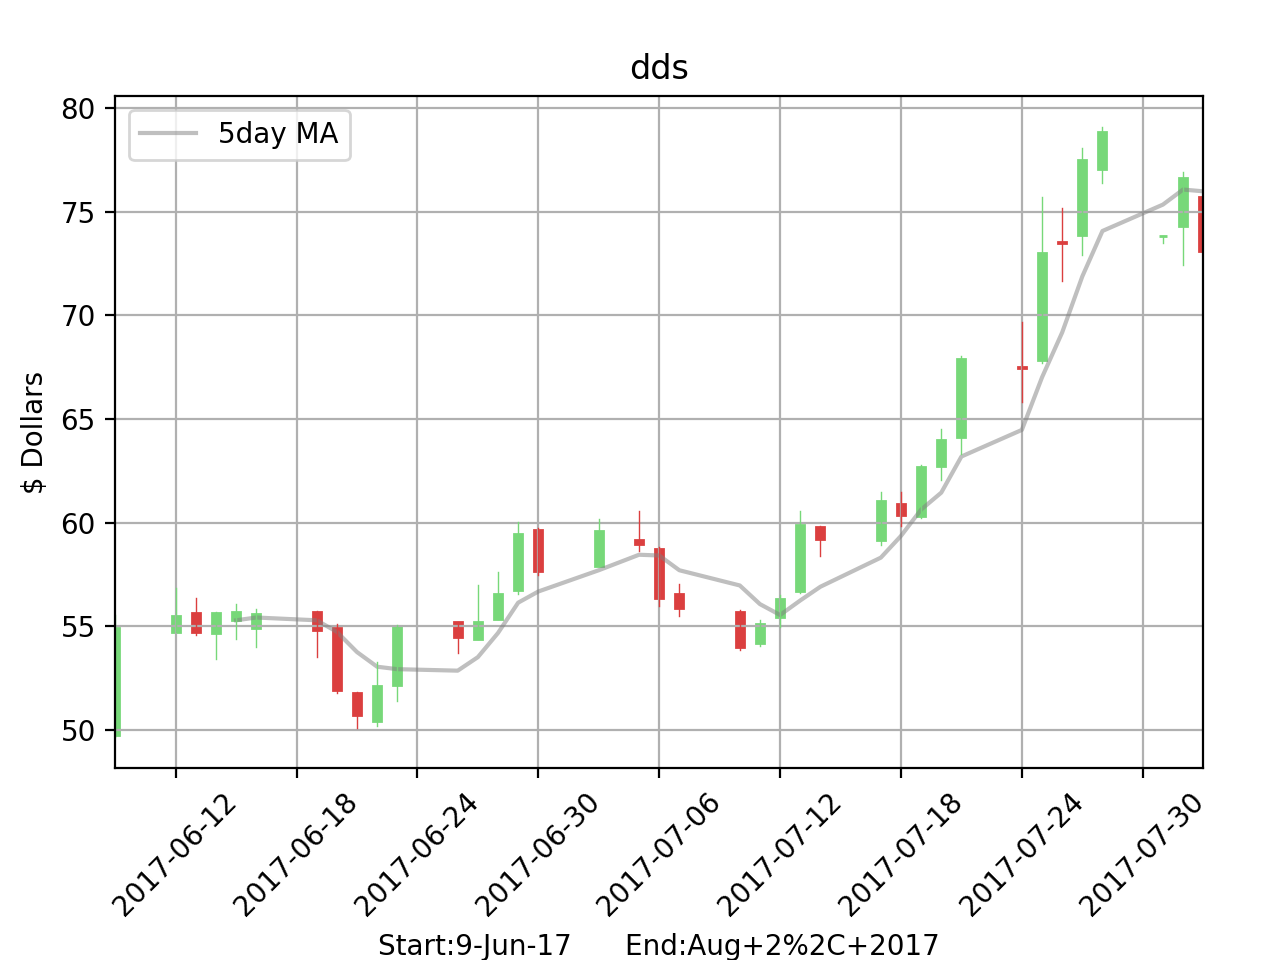

URL is: http://www.google.com/finance/historical?q=dds&startdate=Jan+7%2C+2016&enddate=Aug+2%2C+2017&output=csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:113: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=5,center=False).mean()


In [206]:
graph_data('dds','9-Jun-17','Aug+2%2C+2017')